<a href="https://colab.research.google.com/github/mnsv73/PM2.5-Prediction/blob/master/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the two time series models tested on the given dataset

### 1. LSTM Mosdel

In [0]:
from math import sqrt
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import model_from_json
from sklearn import preprocessing
import math

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load dataset
dataset = pd.read_excel('/content/drive/My Drive/AQI Prediction/AQI Project/data2/station1001_1.xlsx')
z = dataset.isnull().any(axis=1)

In [0]:
#first fill all nan values, data completion
nandat = pd.DataFrame(columns = ['time','PM25_Concentration','O3_Concentration','temperature', 'pressure', 'humidity', 'wind_speed', 'wind_direction', 'weather'])
notnandat = pd.DataFrame(columns = ['time','PM25_Concentration','O3_Concentration','temperature', 'pressure', 'humidity', 'wind_speed', 'wind_direction', 'weather'])
for i in range(len(dataset)):
  if z[i]==True: 
      nandat = nandat.append(dataset.iloc[i], ignore_index=True)
  elif z[i]==False:
    notnandat = notnandat.append(dataset.iloc[i], ignore_index=True)

In [0]:
#Loading the preprocessor model
json_file = open('/content/drive/My Drive/AQI Prediction/AQI Project/data2/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/My Drive/AQI Prediction/AQI Project/data2/station1enc.h5")

In [0]:
x_inputnan = nandat.drop(['time','PM25_Concentration'], axis=1)
x_notnan1 = notnandat.drop(['time','PM25_Concentration'], axis=1)
y_nan1 = pd.DataFrame(nandat, columns = ['PM25_Concentration'])
y_notnan1 = pd.DataFrame(notnandat, columns = ['PM25_Concentration'])
t_nan = pd.DataFrame(nandat, columns=['time'])
t_notnan = pd.DataFrame(notnandat, columns=['time'])

min_max_scaler = preprocessing.MinMaxScaler()
x_nan = min_max_scaler.fit_transform(x_inputnan)
x_notnan = min_max_scaler.fit_transform(x_notnan1)
y_nan = min_max_scaler.fit_transform(y_nan1)
y_notnan = min_max_scaler.fit_transform(y_notnan1)
for i in range(len(x_nan)):
  for j in range (0,7):
    if math.isnan(x_nan[i][j]):
        x_nan[i][j] = -1

In [0]:
x_predicted = loaded_model.predict(x_nan)
for i in range(len(x_nan)):
    for j in range (0, 7):
        if x_nan[i][j] == -1.0 :
            x_nan[i][j] = x_predicted[i][j]

In [0]:
X_scaled = np.concatenate((x_nan, x_notnan), axis=0)
y_scaled = np.concatenate((y_nan, y_notnan), axis=0)
t_final = pd.concat([t_nan, t_notnan], ignore_index=True)
dataset=pd.DataFrame(np.concatenate((X_scaled, y_scaled), axis=1))
dataset['time']=t_final['time']
dataset= dataset.sort_values('time')
dataset=dataset.drop(['time'], axis=1)
dataset = dataset.reset_index(drop=True)
dataset.head

<bound method NDFrame.head of              0         1         2         3         4         5    6         7
0     0.141696  0.424242  0.500000  0.521739  0.244444  0.541667  0.0  0.420561
1     0.142567  0.363636  0.500000  0.608696  0.233333  0.541667  0.0  0.376947
2     0.073171  0.363636  0.500000  0.673913  0.177778  0.541667  0.0  0.386293
3     0.022358  0.333333  0.500000  0.717391  0.188889  0.541667  0.0  0.392523
4     0.000000  0.333333  0.500000  0.728261  0.144444  0.041667  0.0  0.361371
...        ...       ...       ...       ...       ...       ...  ...       ...
7383  0.512195  0.454545  0.500000  0.771739  0.200000  0.083333  0.0  0.239875
7384  0.517422  0.575758  0.500000  0.184783  0.311111  1.000000  0.0  0.258567
7385  0.521487  0.575758  0.500000  0.184783  0.311111  1.000000  0.0  0.261682
7386  0.473287  0.636364  0.423077  0.108696  0.533333  1.000000  0.0  0.239875
7387  0.416376  0.666667  0.384615  0.076087  0.877778  1.000000  0.0  0.236760

[7388 row

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
values = dataset.values
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.141696   0.424242        0.5  ...        0.0   0.420561  0.142567
2   0.142567   0.363636        0.5  ...        0.0   0.376947  0.073171
3   0.073171   0.363636        0.5  ...        0.0   0.386293  0.022358
4   0.022358   0.333333        0.5  ...        0.0   0.392523  0.000000
5   0.000000   0.333333        0.5  ...        0.0   0.361371  0.172161

[5 rows x 9 columns]


In [0]:
# split into train and test sets
values = reframed.values
train = values[:4923, :]
test = values[4923:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4923, 1, 8) (4923,) (2464, 1, 8) (2464,)


Train on 4430 samples, validate on 493 samples
Epoch 1/50
 - 0s - loss: 0.1591 - val_loss: 0.0675
Epoch 2/50
 - 0s - loss: 0.1235 - val_loss: 0.0596
Epoch 3/50
 - 0s - loss: 0.0945 - val_loss: 0.0525
Epoch 4/50
 - 0s - loss: 0.0693 - val_loss: 0.0470
Epoch 5/50
 - 0s - loss: 0.0543 - val_loss: 0.0363
Epoch 6/50
 - 0s - loss: 0.0479 - val_loss: 0.0275
Epoch 7/50
 - 0s - loss: 0.0455 - val_loss: 0.0224
Epoch 8/50
 - 0s - loss: 0.0449 - val_loss: 0.0222
Epoch 9/50
 - 0s - loss: 0.0448 - val_loss: 0.0223
Epoch 10/50
 - 0s - loss: 0.0446 - val_loss: 0.0216
Epoch 11/50
 - 0s - loss: 0.0444 - val_loss: 0.0204
Epoch 12/50
 - 0s - loss: 0.0444 - val_loss: 0.0207
Epoch 13/50
 - 0s - loss: 0.0446 - val_loss: 0.0224
Epoch 14/50
 - 0s - loss: 0.0443 - val_loss: 0.0204
Epoch 15/50
 - 0s - loss: 0.0441 - val_loss: 0.0200
Epoch 16/50
 - 0s - loss: 0.0443 - val_loss: 0.0225
Epoch 17/50
 - 0s - loss: 0.0444 - val_loss: 0.0222
Epoch 18/50
 - 0s - loss: 0.0442 - val_loss: 0.0214
Epoch 19/50
 - 0s - loss: 

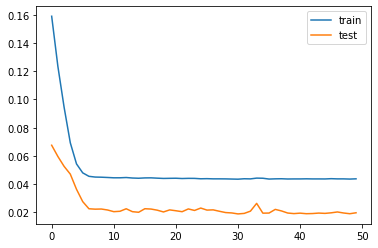

In [0]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.1, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
train_X.shape

(4923, 1, 8)

In [0]:
# make a prediction
yhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))


# invert scaling for forecast
inv_yhat = np.concatenate((yhat, train_X[:, 1:]), axis=1)
inv_yhat = min_max_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y = min_max_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 20.645


In [0]:
df = pd.DataFrame(data=np.column_stack((inv_y,inv_yhat)),columns=['a','p'])
df.to_excel("/content/drive/My Drive/AQI Prediction/AQI Project/data2/lstm.xlsx")

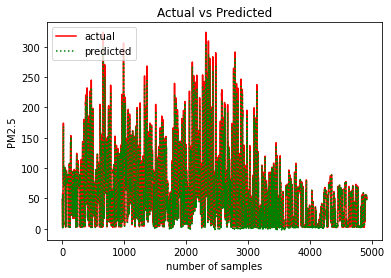

In [0]:
plt.plot(df.a, 'r')
plt.plot(df.p, 'g:')
plt.title('Actual vs Predicted')
plt.ylabel('PM2.5')
plt.xlabel('number of samples')
plt.legend(['actual', 'predicted'], loc='upper left')

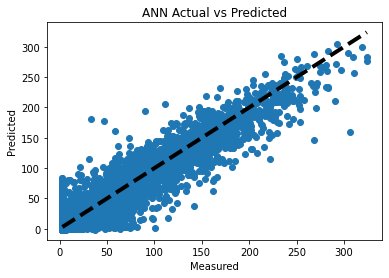

In [0]:
#Scatter plot Predicted v/s Actual Value
fig, ax = plt.subplots()
ax.scatter(df.a, df.p)
ax.plot([df.a.min(), df.a.max()], [df.a.min(), df.a.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('ANN Actual vs Predicted')
plt.show()

In [0]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
  #  acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(df.p, df.a)

{'corr': 0.9418947340624103,
 'mae': 13.20936796334785,
 'mape': 0.6040427179602854,
 'me': -2.337424552490336,
 'minmax': 0.29829959447474785,
 'mpe': 0.22551228875854232,
 'rmse': 20.574787025221568}

### 2. ARIMA Model
Arima stands for Auto Regressive Integrated Moving Average Algorithm. It is one of the best models used for time series prediction.
Here, we will input 4 days of data to predict the next day and see how the model works.
For this model, we first need to check if our data is stationary or not. Hence, we perform tests of stationarity. Three are performed to check stationarity of data.
1. ADF Test
2. KPSS Test
3. PP Test
If the series is not stationary, then we apply differencing technique until we make the series stationary



In [0]:
data = pd.read_excel('/content/drive/My Drive/AQI Prediction/AQI Project/data2/station1001_1.xlsx')

In [0]:
timeseries = data["PM25_Concentration"]
timeseries.head()

0    138
1    124
2    127
3    129
4    119
Name: PM25_Concentration, dtype: int64

In [0]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(timeseries.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   

ADF Statistic: -11.068472
p-value: 0.000000
Critial Values:
   1%, -3.4312388019256654
Critial Values:
   5%, -2.8619327820666984
Critial Values:
   10%, -2.566979073594784


As we can see, our ADF Test Staistic is less then the critical values and p-value is less then 0.05. Hence, our series is stationary based on Stationarity test.

<Figure size 1440x1800 with 0 Axes>

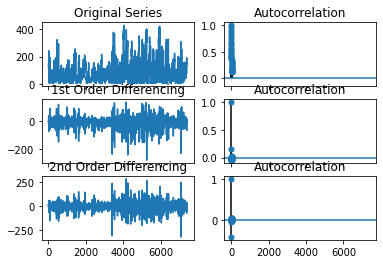

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize = (20, 25))
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(timeseries); axes[0, 0].set_title('Original Series')
plot_acf(timeseries, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(timeseries.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(timeseries.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(timeseries.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(timeseries.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

This was ACF plot of original series, difference of original series and difference of difference of original series. Lets analyse PACF plot of these three series, it will help us set the parameters of ARIMA.

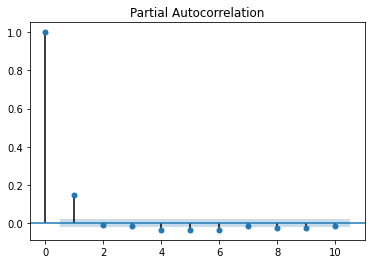

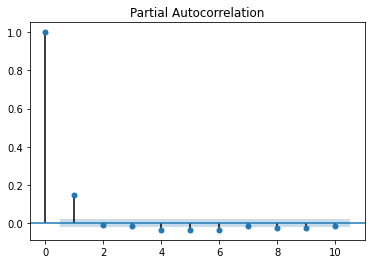

In [0]:
plot_pacf(timeseries.diff().dropna(), lags=10)

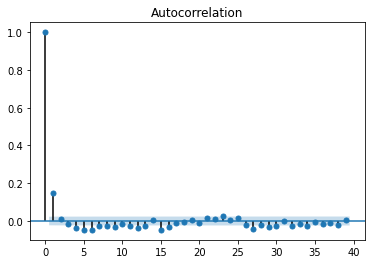

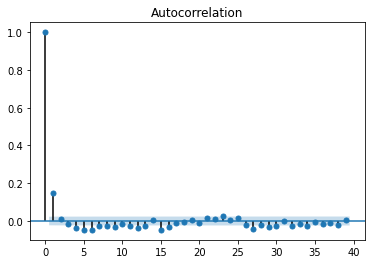

In [0]:
plot_acf(timeseries.diff().dropna())

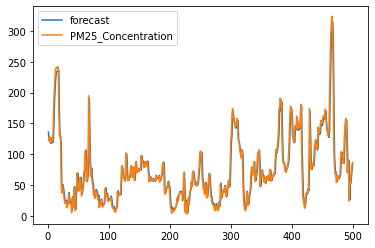

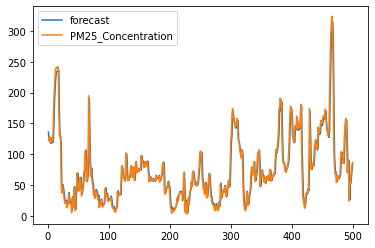

In [0]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(timeseries, order=(1, 0, 0))
results = model.fit()
results.plot_predict(1, 500)

As we can see, training data was fitted properly. Lets try prediciting how this will work on test data, that we analysed.

In [0]:
pip install pmdarima

In [0]:
from pmdarima.arima.utils import ndiffs

y = timeseries

## Adf Test
print(ndiffs(y, test='adf'))  
# KPSS test
print(ndiffs(y, test='kpss'))  
# PP test:
print(ndiffs(y, test='pp'))  

0
1
0


In [0]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, start_p=1, start_q=1, test="adf", seasonal=False, trace=True)
    return automodel

In [0]:
def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="W")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show()

In [0]:
model = ARIMA(timeseries, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:     PM25_Concentration   No. Observations:                 7388
Model:                     ARMA(1, 1)   Log Likelihood              -32663.447
Method:                       css-mle   S.D. of innovations             20.126
Date:                Sun, 24 May 2020   AIC                          65334.893
Time:                        06:38:50   BIC                          65362.524
Sample:                             0   HQIC                         65344.389
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       80.9276      5.547     14.590      0.000      70.056      91.799
ar.L1.PM25_Concentration     0.9509      0.004    255.919      0.000       0.944       0.

In [0]:
train = timeseries[:96]
test = timeseries[97:121]

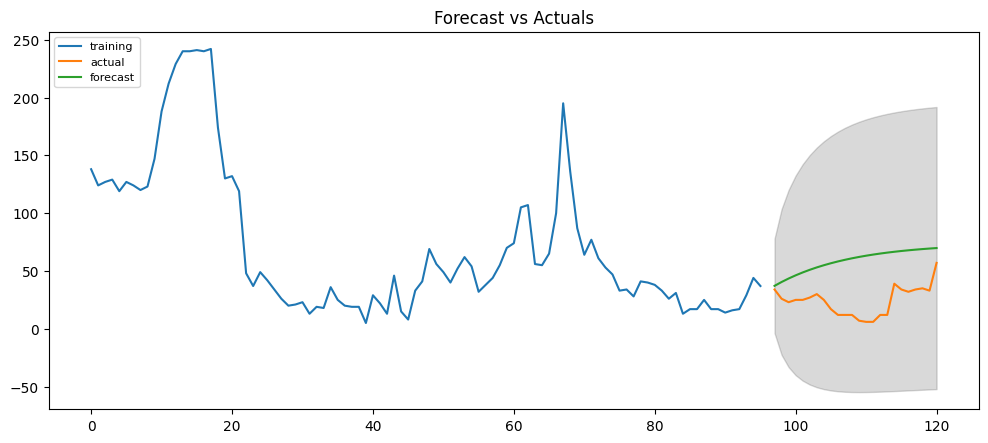

In [0]:
model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(24, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [0]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
  #  acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'corr': 0.07434336588823537,
 'mae': 34.770191092373054,
 'mape': 2.607271845505522,
 'me': 34.770191092373054,
 'minmax': 0.5783055652679985,
 'mpe': 2.607271845505522,
 'rmse': 37.8836135230947}

As we can see, prediction is not so accurate.
Mean Absolute Error is 34.777. 
Hence, we can try putting difference of series and check if accuracy increased. Else, we can increase the training example and reduce the test case.
1. Predicting first order difference in series

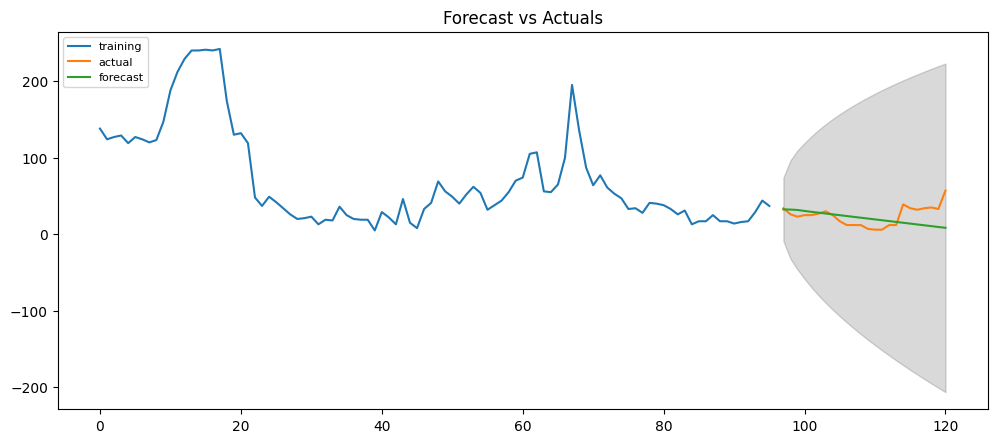

In [0]:
model = ARIMA(train, order=(3, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(24, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [0]:
forecast_accuracy(fc, test.values)

{'corr': -0.2894397454870096,
 'mae': 12.577971678342317,
 'mape': 0.6705656928241449,
 'me': -2.9506433172340287,
 'minmax': 0.41860080343530337,
 'mpe': 0.2655007417997594,
 'rmse': 16.446155367154713}

As we can see, prediction increased slightly, but not significantly.
Mean Absolute Percentage Error is 67 %. Hence, our accracy is 33 % in prediction.

Hence, moving on to our next option.
2. Increased Data

  Over here we increase training data and reduce testing data. 
We train on 100 samples to predict immediate 10 samples.

                              ARIMA Model Results                               
Dep. Variable:     D.PM25_Concentration   No. Observations:                   99
Model:                   ARIMA(2, 1, 1)   Log Likelihood                -440.412
Method:                         css-mle   S.D. of innovations             20.681
Date:                  Sun, 24 May 2020   AIC                            890.823
Time:                          06:39:19   BIC                            903.799
Sample:                               1   HQIC                           896.073
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.1635      2.243     -0.519      0.604      -5.560       3.233
ar.L1.D.PM25_Concentration    -0.2233      0.719     -0.311      0.

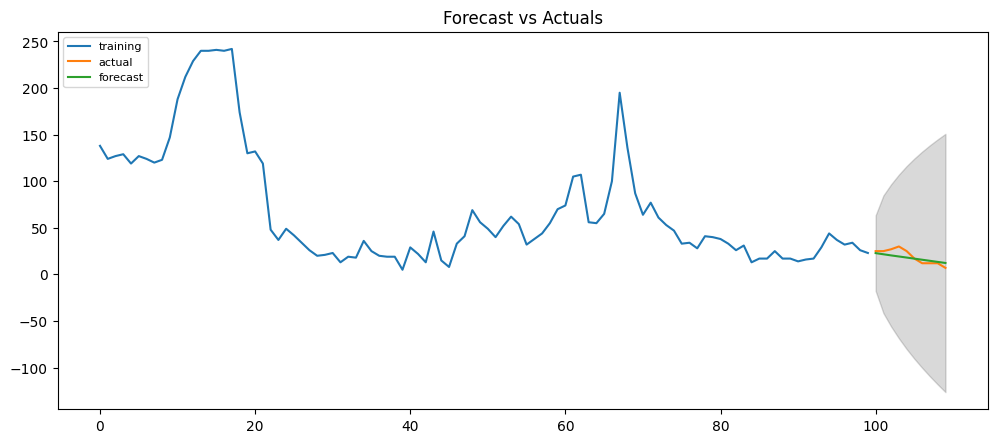

In [0]:
train = timeseries[:100]
test = timeseries[100:110]
model = ARIMA(train, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [0]:
forecast_accuracy(fc, test.values)

{'corr': 0.8827479368883179,
 'mae': 4.2910534150060915,
 'mape': 0.25063891789501086,
 'me': -1.678485683333991,
 'minmax': 0.20569336866000776,
 'mpe': 0.02981824336686357,
 'rmse': 5.230450644839527}

Prediction improved marginally in this case. 

Mean Absolute Percentage Error went down to 25%. Hence, increasing our accuracy to 75% in this case.

Analysing the diagonistics of the model, we import auto ARIMA and check its behaviour.

In [0]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=889.028, BIC=899.409, Time=0.131 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=890.203, BIC=895.393, Time=0.010 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=889.721, BIC=897.506, Time=0.057 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=888.652, BIC=896.437, Time=0.075 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=888.498, BIC=891.093, Time=0.009 seconds
Total fit time: 0.297 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -443.249
Date:                Sun, 24 May 2020   AIC                            888.498
Time:                        06:39:30   BIC                            891.093
Sample:                             0   HQIC                           889.548
  

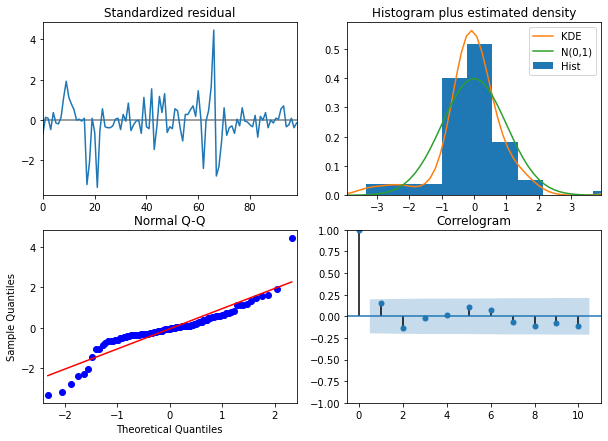

In [0]:
model.plot_diagnostics(figsize=(10,7))
plt.show()